In [1]:
import numpy as np
from TMDP import TMDP
from model_functions import *
from policy_utils import *
import matplotlib.pyplot as plt
import gymnasium as gym
from algorithms import *
from FrozenLake import *
import pandas as pd
import constants
#np.set_printoptions(precision=4)
import math
from policy_utils import *
import torch
import mlflow
from CurriculumMPI import CurriculumMPI
import optuna

nrows = 20
nS = nrows**2
nA = 4
seed = constants.SEEDS[0]
set_policy_seed(seed)
num_bins = 10
gamma = .999
tau = 0.6
dense_reward = False
shape_range=(-1,0)
goal_reward = 1.
#tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)
#mdp = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)
env = FrozenLakeEnv(is_slippery=False, seed=seed, 
                        desc=generate_random_map(nrows, seed=seed), 
                        reward_shape=False,
                        num_bins=num_bins,
                        dense_reward=dense_reward,
                        shape_range=shape_range,
                        goal_reward=goal_reward,
                        )
xi = np.ones(env.nS) * 1/env.nS
tmdp = TMDP(env, xi, tau=tau, gamma=gamma, seed=seed)

Current seed for result reproducibility: 2999


In [2]:
res = bellman_optimal_q(tmdp.env.P_mat, tmdp.env.reward, tmdp.gamma)
Q = res["Q"]
V = compute_V_from_Q(Q, get_policy(Q))
j_opt = compute_expected_j(V, tmdp.env.mu)
print("optimal performance: ",j_opt)

optimal performance:  0.9636582956114175


In [3]:
"""env.render_mode = "human"
env.render()"""

'env.render_mode = "human"\nenv.render()'

In [4]:
model_lr = 0.373715
pol_lr = 0.215723
temp = 5
batch_size = 16
epochs = 1

episodes = 9900000
final_temp=1
param_decay=True
lam = 1

check_convergence=True
param_decay=True
biased=False
debug = True

In [5]:
curr_MPI = CurriculumMPI(tmdp)
curr_MPI.train(model_lr, pol_lr, batch_size=batch_size, 
                        lam=lam, temp=temp, final_temp=final_temp,
                        episodes=episodes, check_convergence=check_convergence,
                        param_decay=param_decay, biased=biased,
                        debug=debug, epochs=epochs)   

Model advantage is negative 0.0
d_inf_model: 1.995, d_exp_model: 1.9950473308563232
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 26 reward: 0.0 length: 26 #teleports:15
Time for bound evaluation:  0.03479409217834473
Model advantage is negative 0.0
d_inf_model: 1.995, d_exp_model: 1.9950473308563232
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 45 reward: 0.0 length: 19 #teleports:11
Time for bound evaluation:  0.028949975967407227
Model advantage is negative 0.0
d_inf_model: 1.995, d_exp_model: 1.9950473308563232
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 91 reward: 0.0 length: 46 #teleports:29
Time for bound evaluation:  0.02704000473022461
Model advantage is negative 0.0
d_inf_model: 1.995, d_exp_model: 1.9950473308563232
No valid pairs found
[(0.0, 0.6)]
Alpha*: 0.0 tau*: 0.6 Episode: 122 reward: 0.0 length: 31 #teleports:22
Time for bound evaluation:  0.02408885955810547
Model advantage is negative 0.0
d_inf_model: 1.995

KeyboardInterrupt: 

In [ ]:
#V_Q = compute_V_from_Q(Q, get_policy(curr_MPI.Q))
V_curr = compute_V_from_Q(Q, get_softmax_policy(curr_MPI.theta, temperature=1e-5))

j_curr = compute_expected_j(V_curr, tmdp.env.mu)
j_opt = compute_expected_j(V, tmdp.env.mu)

print("optimal performance: ",j_opt)
print("curriculum performance: ", j_curr)


optimal performance:  -1.651342808845201
curriculum performance:  -1.651342808845201


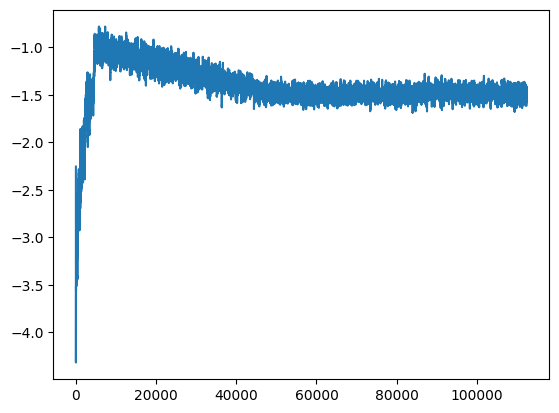

In [ ]:
import matplotlib.pyplot as plt
rewards = curr_MPI.reward_records
# Generate recent 50 interval average
avg_rewards = []
for idx in range(len(rewards)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = rewards[:idx+1]
    else:
        avg_list = rewards[idx-49:idx+1]
    avg_rewards.append(np.average(avg_list)/batch_size)
# Plot
#plt.plot(rewards)
plt.plot(avg_rewards)

In [ ]:
from experiment_result_utils import *
test_rewards = test_policies(tmdp, curr_MPI.thetas, 100, 1e-5)

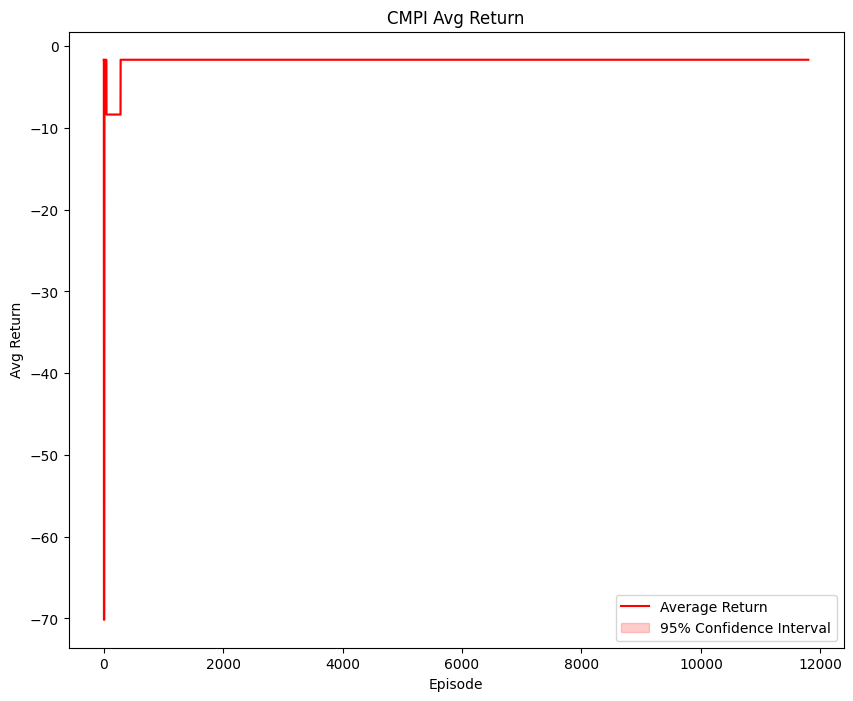

In [ ]:
rewards_fig = plot_avg_test_return([test_rewards], f"CMPI Avg Return")


In [ ]:
pi = get_policy(get_softmax_policy(curr_MPI.theta, temperature=1e-4))
#pi = get_policy(Q)

In [ ]:
print(curr_MPI.theta[0])
print(pi[0])

[-31.60079787  26.53836358  36.60016821 -31.53773392]
[0. 0. 1. 0.]


In [ ]:

tmdp.update_tau(0.)
tmdp.reset()
done = False
step = 0
env.render_mode = "human"
while True:
    s = tmdp.env.s
    a = select_action(pi[s])
    s_prime, reward, flags, prob = tmdp.step(a)
    print("state {} action {} next state {} reward {}".format(s, a, s_prime, reward))
    if flags["done"]:
        tmdp.reset()
        break
    step +=1
    if step > min(100,nrows*3):
        break


FileNotFoundError: No such file or directory: '/Users/cris/Desktop/TMDP/img/hole.png'.